## Opportunistic Betting on MMA Fights

While we typically think of regression trees as offering a yes or no answer - success or failure, they actually offer us a sense of the probability of success or failure. In cases where we do not have to take action on every observation (betting, for instance, where we can simply choose to abstain if the result seems too uncertain), we can take advantage of those probabilities to decide when to place a bet and, if we do, which side to bet on.

### Preliminary function and package loading

In [1]:
import os
for f in os.listdir('./fun/'): exec(open('./fun/'+f).read())
del f

import pandas as pd
import numpy as np
import math
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Initial data loading

In [2]:
# Load data
data = pd.read_csv("./out/d_fight_level_dataset_1line.csv", index_col = 0)
data.reset_index(inplace = True)

# Change winner to binary 1/0:
data.Winner = data.Winner.apply(lambda x: np.where(x == -1, 0, 1))

# Initial features and target
features = pd.Series(data.columns, index = data.columns)
target = "Winner"

#### A note about winning
As shown below, the percentage of wins is about 63%, which seems odd: one would expect the winning percentage to be roughly 50% as it should be random. This dataset is from the perspective of the "red" fighter, however. In the UFC, the fighter who is better known or expected to win is typically given the red designation (see <href> https://www.sportingnews.com/us/boxing/news/when-red-corner-vs-blue-corner-is-unfair/139ounrjdg6j11r0idf05101w7> </href> and <href> http://forum.mmajunkie.com/forum/threads/red-corner-vs-blue-corner.30804/ </href> for some discussions on the issue). So, this kind of result can be expected and we can take advantage of it a bit in our analysis.

In [3]:
pd.DataFrame(data[target].value_counts(normalize = True))

,Winner
1,0.663499
0,0.336501


### Feature engineering
We drop features that seem less relevant or may be repetitive

In [4]:
# Remove referree, date, location, winner, title_bout, weight_class, no_of_rounds
features.drop(index = ["Referee", "date", "location", "Winner", "title_bout",
                       "weight_class", "no_of_rounds"], inplace = True)

# Different sorts of wins are relatively sparce and are likely perfectly colinear
# with number of wins
features.drop(index = ["Diff_win_by_Decision_Majority",
                       "Diff_win_by_Decision_Split",
                       "Diff_win_by_Decision_Unanimous",
                       "Diff_win_by_KO/TKO",
                       "Diff_win_by_Submission",
                       "Diff_win_by_TKO_Doctor_Stoppage"], inplace = True)

# Diff_draw is mostly NA/0
features.drop(index = "Diff_draw", inplace = True)

# Delete two rows with missing data
delete = np.where(data[features].apply(lambda x: np.sum(np.isnan(x)) != 0, axis = 1))
delete = [x for x in delete for x in x]
data.drop(index = delete, inplace = True)

### Model development
Unlike many datasets, ours has date as an element. Instead of doing a typical train-test split, which is random, we can instead divide the dataset by time. We can create an initial model based on what we would have known at a point in time and see how it would have worked over the period of time thereafter. This is common - and preferred - in many discplines, like finance. It also matches more closely with reality, in that we can simulate what we would have done based on data we had at that time.
#### Model/functions

In [5]:
scaler = StandardScaler(copy = False)

X = data[features]
y = data[target]

m = RandomForestRegressor( 
    n_estimators = 400, 
    min_samples_leaf = 0.05, 
    random_state = 841)

#### Dates and initial model
To start, we determine the number of individual dates we have in the dataset (as there often is more than one fight on a given day) and use the first 60% of dates to develop our initial model.

In [6]:
dates = np.unique(data.date)
split = math.floor(len(dates) * .6)

len(data[data.date <= dates[split]].index)

maxf = len(data[data.date <= dates[split]].index)

X_train = data[features].iloc[range(maxf)]
y_train = data[target].iloc[range(maxf)]

scaler.fit(X_train)
X_train = scaler.transform(X_train, copy = False)

m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.05, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=841, verbose=0,
                      warm_start=False)

#### Initial model diagnostics
Given that, as we previously mentioned, the win percentage is approximately 63%, it is interesting to note that the model performs poorly between predictions of 55% and 60%. The results between 60% and 65% do not seem particularly differentiated from the average probability of winning of 63%.

In [7]:
y_pred = pd.DataFrame(data = {"prediction" : m.predict(X_train)})
y_pred["actual"] = y_train.reset_index(drop = True)
y_pred["pred_bucket"] = pd.cut(y_pred.prediction, bins = np.arange(.45, 1.01, .05))

y_diagnostics = y_pred[["actual", "pred_bucket"]].groupby("pred_bucket").aggregate(["sum", "count"])
y_diagnostics.columns = ["sum", "count"]
y_diagnostics["pct"] = y_diagnostics["sum"] / y_diagnostics["count"]

y_diagnostics

,sum,count,pct
pred_bucket,,,
"(0.45, 0.5]",29,100,0.290000
"(0.5, 0.55]",76,182,0.417582
"(0.55, 0.6]",135,250,0.540000
"(0.6, 0.65]",165,252,0.654762
"(0.65, 0.7]",142,176,0.806818
"(0.7, 0.75]",77,87,0.885057
"(0.75, 0.8]",27,27,1.000000
"(0.8, 0.85]",2,3,0.666667
"(0.85, 0.9]",3,3,1.000000


#### Develping an expanding window model
Since this data is temporal, it seems that it would always be beneficial to include all information known at each particular point in time. So, for each date after the initial model, we re-estimate the regression tree with all of the available data and then predict the results of fights for that day. Given the weakness of the model when the prediction of winning is between 55% and 65%, we will choose to make no bet for those fights. For probabilities of less than 55%, we will bet the red fighter to lose; for probabilities of greater than 65%, we will bet the red fighter to win. We assume a bet of $100 per fight at even odds (it is a bit of a stretch to imagine even odds, but this analysis can be updated with odds data or the predicted probability can be compared with available odds at the time to determine a more refined course of action).

First, a helper function:

In [8]:
def determine_result(x):
    if x.action == "Bet Win":
        if x.actual == 1:
            return "Won"
        else:
            return "Lost"
    elif x.action == "Bet Loss":
        if x.actual == 0:
            return "Won"
        else:
            return "Lost"
    else:
        return "No Action"

Second, the analysis to determine the bets to make at each point in time, based only on the information known up until that date:

In [9]:
full_results = pd.DataFrame()

for x in range(split, len(dates)):
    maxf = len(data[data.date <= dates[x]].index)
    X_train = data[features].iloc[range(maxf)]
    scaler.fit(X_train)
    X_train = scaler.transform(X_train, copy = False)
    y_train = data[target].iloc[range(maxf)]
    m.fit(X_train, y_train)
    
    fights = np.where(data.date == dates[x])
    X_test = data[features].iloc[fights]
    X_test = scaler.transform(X_test, copy = False)
    y_test = data[target].iloc[fights]
    
    result = pd.DataFrame(data = {"date" : data.iloc[fights].date,
                                  "prediction" : m.predict(X_test),
                                  "actual" : y_test})
    result["action"] = result.apply(lambda x: np.where(x.prediction < .55, "Bet Loss",
          np.where(x.prediction > .65, "Bet Win", "No Action")), axis = 1)
    result["result"] = result.apply(determine_result, axis = 1)
    result["wager_result"] = result.apply(lambda x: np.where(x.result == "Won", 100,
    np.where(x.result == "Lost", -100, 0)), axis = 1)
    full_results = full_results.append(result, ignore_index = True)

full_results["cumulative_wager_result"] = full_results.wager_result.cumsum()

### Model diagnostics
This betting model (with the caveat about not taking offered betting odds into account) performs well. Based on our hypothetical bet amount of \\$100 per fight, we would have earned \$32,900 over the last 4-1/2 years.

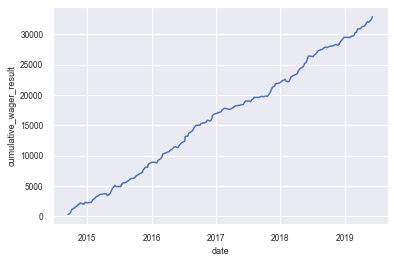

In [10]:
full_results_summary = full_results[["date", "cumulative_wager_result"]].groupby("date").aggregate(np.max)
full_results_summary["date"] = full_results_summary.index
full_results_summary.date = full_results_summary.date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

sns.set(font_scale = .75)
sns.lineplot(x = "date", y = "cumulative_wager_result", data = full_results_summary)